# ca数据训练
## 导入相应的包


In [1]:
import os
import sys
import cv2

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

import numpy as np
import tensorflow as tf


# 数据增强
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2, ResNet50, Xception, EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, model_from_json

# 添加路径，以能正常导入mbsh、trainer
sys.path.insert(0, r"..\Lib\trainer")



from mbsh import create_app
from mbsh.core.models import SmallModel
from mbsh.core.images import read_to_pd,TrainArgs
from mbsh.core.plot import Plot

from trainer import Trainer

# tf.compat.v1.disable_eager_execution()

2022-05-30 13:57:42,865 - INFO - __init__.py - init_logger - 58 - ini  logger file D:\projects\Vision\Lib\logs\kernel-cb4125db-90f1-4583-8fc5-dd42e7237662.log


use temp dir:d:\znyx\temp


In [ ]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
 
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

In [5]:
# model_id = 100 ResNet 模型 loss: 0.2732 - acc: 0.9096 - val_loss: 0.4109 - val_acc: 0.8740

##  路径常量设置

In [3]:
# 样本数据根目录
# 根目录下res中按分类标签存放各类型图像
# cache目录存放训练的结果模型
# 
# root_path = r'/home/endoangel/public/模型算法组/训练数据/zhangkuo/imgs_wei_29'
root_path = r'\\192.168.0.154\数据\口咽部\大部位27分类'
# 是否使用平衡数据做训练
use_increase = False

# 训练采用的模型名称
model_name = 'effi'


# 模型保存id
model_id = 2802


IMG_SIZE = 224
img_size = (IMG_SIZE, IMG_SIZE)

# img_size = (360,360)
# 训练迭代次数
epochs = 50


# 训练每批次样本数
batch_size = 16

In [4]:
# app创建
app = create_app(os.getenv('FLASK_CONFIG') or 'default')
app.app_context().push()

2022-05-30 13:57:49,138 - INFO - __init__.py - create_app - 71 - db url =sqlite:///D:\projects\Vision\Lib\trainer\../data\production.db


In [5]:
cache_path = root_path + '/cache'
res_path = root_path + '/res'

# res数据分割后的训练和验证集目录
res_train_path = root_path + '/res_train'
res_test_path = root_path + '/res_val'

# 数据平衡后的训练和验证集目录
train_path = root_path + '/train'
test_path = root_path + '/test'

# 图片预测错误存放目录
pred_err_path = root_path + '/pred_err_effi'


# trainer创建

# 从数据库获取model信息，如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list
# sm = SmallModel.query.get(sm_name)

# 生成 trainer
sm_name = 'ca'
# sm_desc_list =  ["喉","上颚","咽后壁","右梨状窝","左梨状窝"]
sm_desc_list =  ["不确定", "食管","贲门","前壁","后壁","大弯","小弯侧","前壁", 
                "后壁","小弯","大弯侧","前壁","后壁","小弯","大弯侧",
                 "十二指肠球部", "十二指肠降部","后壁","前壁","小弯侧","前壁","后壁",
                 "小弯","前壁","后壁","大弯","小弯侧","咽部"]
# 食管、贲门、正镜胃体中上部（前壁、后壁、大弯、小弯侧）、正镜胃体下部（前壁、后壁、小弯、大弯侧）、
# 胃窦（前壁、后壁、小弯、大弯侧）、十二指肠（球部和降部）、
# 倒镜胃角（后壁、前壁、小弯侧）、倒镜胃体中上部（前壁、后壁、小弯）、倒镜胃底（前壁、后壁、大弯、小弯侧

sm = SmallModel(sm_name)

sm.desc_list = sm_desc_list
trainer = Trainer(sm)
trainer.img_size = img_size
trainer.target_fold = root_path

# 类型个数
types_num = len(trainer.desc_list)

desc_list = [str(x) + '-' + trainer.desc_list[x] for x in range(0,types_num)]
print(desc_list)

['0-不确定', '1-食管', '2-贲门', '3-前壁', '4-后壁', '5-大弯', '6-小弯侧', '7-前壁', '8-后壁', '9-小弯', '10-大弯侧', '11-前壁', '12-后壁', '13-小弯', '14-大弯侧', '15-十二指肠球部', '16-十二指肠降部', '17-后壁', '18-前壁', '19-小弯侧', '20-前壁', '21-后壁', '22-小弯', '23-前壁', '24-后壁', '25-大弯', '26-小弯侧', '27-咽部']


## 开始训练
### 数据增强

In [6]:
def img_rgb2_bgr(img):
    return img[: , : , : : -1]

# 图片生成器
# https://keras-cn.readthedocs.io/en/latest/preprocessing/image/#imagedatagenerator
train_datagen =  ImageDataGenerator(       
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        rotation_range=10,
        zoom_range=0.1,
        fill_mode='constant',
#         vertical_flip=True,
#         horizontal_flip=True,
        preprocessing_function = img_rgb2_bgr,
    )

test_datagen =  ImageDataGenerator(
        fill_mode='constant',
        preprocessing_function = img_rgb2_bgr,
    )

# 训练数据与测试数据
cls_mode = 'binary' if types_num == 2 else 'categorical'
train_generator = train_datagen.flow_from_directory(
        res_train_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)
test_generator = test_datagen.flow_from_directory(
        res_test_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)

train_samples = train_generator.samples
valid_samples = test_generator.samples

Found 70552 images belonging to 28 classes.
Found 7395 images belonging to 28 classes.


### 训练
#### 先全部冻结训练

In [7]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# Create the base model EfficientNetB4
base_model = EfficientNetB4(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
# 冻结所有层
# base_model.trainable = False
base_model.trainable = True

2022-05-30 13:58:12,190 - DEBUG - attrs.py - __getitem__ - 77 - Creating converter from 3 to 5


In [8]:
from tensorflow.keras.optimizers import SGD, Adam
setting = (1, 'sigmoid', 'binary_crossentropy') if types_num == 2 else (types_num, 'softmax', 'categorical_crossentropy')
# Add a classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
prediction = Dense(setting[0], activation=setting[1], name='dense')(x)

model = Model(base_model.input, prediction)

# model = trainer.load_model(22)
base_learning_rate = 0.001
Adam = Adam(lr=base_learning_rate/10)
model.compile(optimizer=Adam, loss=setting[2], metrics=['accuracy'])


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
print("Number of layers in the base model: ", len(base_model.layers))
# 在 fine_tune_at 之后放开训练,根据情况修改  175
fine_tune_at = 813

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable =  True

Number of layers in the base model:  475


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block2a_expand_conv (Conv2D)   (None, 112, 112, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 14  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

 block3a_dwconv (DepthwiseConv2  (None, 28, 28, 192)  4800       ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 28, 28, 192)  768        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 28, 28, 192)  0          ['block3a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3a_se_squeeze (GlobalAver  (None, 192)         0           ['block3a_activation[0][0]']     
 agePoolin

 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block3c_se_reduce[0][0]']      
                                                                                                  
 block3c_se_excite (Multiply)   (None, 28, 28, 336)  0           ['block3c_activation[0][0]',     
                                                                  'block3c_se_expand[0][0]']      
          

 block4a_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 14, 14, 336)  0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 14, 14, 112)  37632       ['block4a_se_excite[0][0]']      
          

                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 112)  0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 14, 14, 112)  0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block4c_add[0][0]']            
          

                                                                                                  
 block4e_add (Add)              (None, 14, 14, 112)  0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block4e_add[0][0]']            
                                                                                                  
 block4f_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block4f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4f_expand_activation (Act  (None, 14, 14, 672)  0          ['block4f_expand_bn[0][0]']      
 ivation) 

 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 14, 14, 960)  24000      ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 960)  0          ['block5b_bn[0][0]']             
 )                                                                                                
          

 block5d_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 960)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 960)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5d_se_squeeze[0][0]']     
          

                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 960)         0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5f_se_reshape[0][0]']     
                                                                                                  
 block5f_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5f_se_reduce[0][0]']      
                                                                                                  
 block5f_s

                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 7, 7, 1632)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6b_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6d_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 7, 7, 272)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 7, 7, 272)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
          

                                                                                                  
 block6f_drop (Dropout)         (None, 7, 7, 272)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 7, 7, 272)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6h_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1632)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1632)  14688       ['block7a_expand_activation[0][0]
 D)       

 dropout (Dropout)              (None, 1792)         0           ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dense (Dense)                  (None, 28)           50204       ['dropout[0][0]']                
                                                                                                  
Total params: 17,724,027
Trainable params: 17,598,820
Non-trainable params: 125,207
__________________________________________________________________________________________________


In [11]:
def fit_gen(model, model_id, epochs=5):
    class_mode = 'binary' if types_num == 2 else 'categorical'
    print("train from imgs model_id=%s ,class_mode=%s" % (model_id, class_mode))
                
    # 创建cache目录
    if not os.path.exists(cache_path):
        os.mkdir(cache_path)
    
    weight_path = cache_path + '/weights' + str(model_id) + '.hdf5'
    
    # EarlyStoppingy原型：
    # EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    early_stop = EarlyStopping(monitor='val_loss', patience=8)
    
    # ModelCheckpoint原型：
    # ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    check_point = ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    
    # callbacks设置
    callbacks = [early_stop, check_point]
    
    
    history = model.fit(
        train_generator,
        epochs = epochs,
        steps_per_epoch = train_samples // batch_size,
        validation_data = test_generator,
        validation_steps = valid_samples // batch_size,
        callbacks = callbacks)
    return history

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [17]:
import logging
logging.basicConfig(level=logging.INFO)

In [18]:
history = fit_gen(model, model_id, epochs=50 )

2022-05-30 14:00:15,094 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,105 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,117 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,129 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,140 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,152 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,165 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,177 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,188 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,200 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,211 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,235 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,246 - DEBUG - Image.py - close - 606 - Error closing: fp

train from imgs model_id=2802 ,class_mode=categorical


2022-05-30 14:00:15,292 - DEBUG - Image.py - close - 606 - Error closing: fp


Epoch 1/50


2022-05-30 14:00:15,372 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,386 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,399 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,410 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,421 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,433 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,446 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,458 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,469 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,481 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,492 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,503 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:15,515 - DEBUG - Image.py - close - 606 - Error closing: fp

   1/4409 [..............................] - ETA: 56:42 - loss: 3.2208 - accuracy: 0.0625

2022-05-30 14:00:16,138 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,152 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,163 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,175 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,186 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,201 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,216 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,227 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,238 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,254 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,266 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,282 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,293 - DEBUG - Image.py - close - 606 - Error closing: fp

   2/4409 [..............................] - ETA: 24:36 - loss: 3.2292 - accuracy: 0.0312

2022-05-30 14:00:16,473 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,487 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,499 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,510 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,522 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,534 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,545 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,560 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,575 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,586 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,601 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,617 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,628 - DEBUG - Image.py - close - 606 - Error closing: fp

   3/4409 [..............................] - ETA: 24:42 - loss: 3.2574 - accuracy: 0.0417

2022-05-30 14:00:16,807 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,822 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,834 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,845 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,856 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,867 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,879 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,893 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,908 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,931 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,942 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,953 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:16,970 - DEBUG - Image.py - close - 606 - Error closing: fp

   4/4409 [..............................] - ETA: 24:38 - loss: 3.2709 - accuracy: 0.0469

2022-05-30 14:00:17,144 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,162 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,173 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,185 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,197 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,208 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,219 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,237 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,262 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,275 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,286 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,298 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,310 - DEBUG - Image.py - close - 606 - Error closing: fp

   5/4409 [..............................] - ETA: 24:45 - loss: 3.2672 - accuracy: 0.0375

2022-05-30 14:00:17,484 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,501 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,513 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,525 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,544 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,557 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,570 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,582 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,596 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,607 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,625 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,639 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,651 - DEBUG - Image.py - close - 606 - Error closing: fp

   6/4409 [..............................] - ETA: 24:42 - loss: 3.2842 - accuracy: 0.0521

2022-05-30 14:00:17,823 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,837 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,848 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,859 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,871 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,888 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,902 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,914 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,942 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,956 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,967 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,982 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:17,993 - DEBUG - Image.py - close - 606 - Error closing: fp

   7/4409 [..............................] - ETA: 24:47 - loss: 3.2728 - accuracy: 0.0625

2022-05-30 14:00:18,163 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,176 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,192 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,203 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,224 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,236 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,248 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,258 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,273 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,284 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,296 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,308 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,323 - DEBUG - Image.py - close - 606 - Error closing: fp

   8/4409 [..............................] - ETA: 24:48 - loss: 3.2574 - accuracy: 0.0781

2022-05-30 14:00:18,503 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,517 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,530 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,546 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,563 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,576 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,588 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,604 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,616 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,627 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,639 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,655 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,666 - DEBUG - Image.py - close - 606 - Error closing: fp

   9/4409 [..............................] - ETA: 24:46 - loss: 3.2558 - accuracy: 0.0903

2022-05-30 14:00:18,845 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,858 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,873 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,884 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,896 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,907 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,928 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,942 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,960 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,975 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:18,989 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,000 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,011 - DEBUG - Image.py - close - 606 - Error closing: fp

  10/4409 [..............................] - ETA: 24:48 - loss: 3.2569 - accuracy: 0.0875

2022-05-30 14:00:19,179 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,192 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,210 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,222 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,233 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,244 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,257 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,269 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,287 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,299 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,311 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,323 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,338 - DEBUG - Image.py - close - 606 - Error closing: fp

  11/4409 [..............................] - ETA: 24:48 - loss: 3.2405 - accuracy: 0.0966

2022-05-30 14:00:19,518 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,530 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,549 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,561 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,573 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,588 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,599 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,611 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,622 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,634 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,645 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,656 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,668 - DEBUG - Image.py - close - 606 - Error closing: fp

  12/4409 [..............................] - ETA: 24:52 - loss: 3.2467 - accuracy: 0.0938

2022-05-30 14:00:19,878 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,894 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,906 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,921 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,935 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,947 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,958 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,971 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:19,986 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,001 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,015 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,025 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,037 - DEBUG - Image.py - close - 606 - Error closing: fp

  13/4409 [..............................] - ETA: 24:51 - loss: 3.2450 - accuracy: 0.0962

2022-05-30 14:00:20,206 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,220 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,231 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,243 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,255 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,266 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,281 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,293 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,304 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,322 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,334 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,358 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,369 - DEBUG - Image.py - close - 606 - Error closing: fp

  14/4409 [..............................] - ETA: 24:50 - loss: 3.2377 - accuracy: 0.1027

2022-05-30 14:00:20,544 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,562 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,575 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,586 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,599 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,613 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,630 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,642 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,659 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,670 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,682 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,695 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,711 - DEBUG - Image.py - close - 606 - Error closing: fp

  15/4409 [..............................] - ETA: 24:49 - loss: 3.2238 - accuracy: 0.1167

2022-05-30 14:00:20,882 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,898 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,910 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,921 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,936 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,947 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,959 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,973 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:20,987 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,002 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,016 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,034 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,046 - DEBUG - Image.py - close - 606 - Error closing: fp

  16/4409 [..............................] - ETA: 24:51 - loss: 3.2162 - accuracy: 0.1133

2022-05-30 14:00:21,227 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,240 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,257 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,269 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,280 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,291 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,305 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,319 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,332 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,347 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,359 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,381 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,397 - DEBUG - Image.py - close - 606 - Error closing: fp

  17/4409 [..............................] - ETA: 24:52 - loss: 3.2106 - accuracy: 0.1140

2022-05-30 14:00:21,571 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,586 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,598 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,609 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,621 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,632 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,644 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,656 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,668 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,680 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,691 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,702 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,716 - DEBUG - Image.py - close - 606 - Error closing: fp

  18/4409 [..............................] - ETA: 24:50 - loss: 3.2048 - accuracy: 0.1146

2022-05-30 14:00:21,906 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,919 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,931 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,948 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,972 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,985 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:21,996 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,009 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,023 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,035 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,046 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,057 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,069 - DEBUG - Image.py - close - 606 - Error closing: fp

  19/4409 [..............................] - ETA: 24:48 - loss: 3.2094 - accuracy: 0.1118

2022-05-30 14:00:22,239 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,252 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,264 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,275 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,287 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,298 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,313 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,328 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,341 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,353 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,364 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,375 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,387 - DEBUG - Image.py - close - 606 - Error closing: fp

  20/4409 [..............................] - ETA: 24:48 - loss: 3.1919 - accuracy: 0.1187

2022-05-30 14:00:22,576 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,589 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,600 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,611 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,625 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,636 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,647 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,662 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,673 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,687 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,698 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,711 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,723 - DEBUG - Image.py - close - 606 - Error closing: fp

  21/4409 [..............................] - ETA: 24:46 - loss: 3.1963 - accuracy: 0.1161

2022-05-30 14:00:22,909 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,924 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,939 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,951 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,963 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,975 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:22,987 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,002 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,013 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,032 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,044 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,056 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,068 - DEBUG - Image.py - close - 606 - Error closing: fp

  22/4409 [..............................] - ETA: 24:47 - loss: 3.1961 - accuracy: 0.1165

2022-05-30 14:00:23,257 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,274 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,286 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,298 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,309 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,321 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,332 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,347 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,359 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,372 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,384 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,395 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,407 - DEBUG - Image.py - close - 606 - Error closing: fp

  23/4409 [..............................] - ETA: 24:47 - loss: 3.1982 - accuracy: 0.1114

2022-05-30 14:00:23,599 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,612 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,624 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,636 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,648 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,662 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,673 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,684 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,696 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,714 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,728 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,739 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,750 - DEBUG - Image.py - close - 606 - Error closing: fp

  24/4409 [..............................] - ETA: 24:46 - loss: 3.2036 - accuracy: 0.1094

2022-05-30 14:00:23,929 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,944 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,955 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,967 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,980 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:23,994 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,004 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,018 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,029 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,041 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,053 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,064 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,080 - DEBUG - Image.py - close - 606 - Error closing: fp

  25/4409 [..............................] - ETA: 24:44 - loss: 3.2050 - accuracy: 0.1100

2022-05-30 14:00:24,260 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,274 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,286 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,296 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,309 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,325 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,336 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,348 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,360 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,371 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,386 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,397 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,408 - DEBUG - Image.py - close - 606 - Error closing: fp

  26/4409 [..............................] - ETA: 24:44 - loss: 3.1987 - accuracy: 0.1082

2022-05-30 14:00:24,600 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,614 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,625 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,637 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,648 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,659 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,671 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,683 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,700 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,712 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,726 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,737 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,749 - DEBUG - Image.py - close - 606 - Error closing: fp

  27/4409 [..............................] - ETA: 24:44 - loss: 3.2018 - accuracy: 0.1088

2022-05-30 14:00:24,951 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,968 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,985 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:24,997 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,011 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,022 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,037 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,051 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,063 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,074 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,086 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,108 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,120 - DEBUG - Image.py - close - 606 - Error closing: fp

  28/4409 [..............................] - ETA: 24:44 - loss: 3.1930 - accuracy: 0.1161

2022-05-30 14:00:25,286 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,299 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,311 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,326 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,340 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,352 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,364 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,379 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,393 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,408 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,422 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,435 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,450 - DEBUG - Image.py - close - 606 - Error closing: fp

  29/4409 [..............................] - ETA: 24:44 - loss: 3.1933 - accuracy: 0.1164

2022-05-30 14:00:25,629 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,642 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,655 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,666 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,678 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,699 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,719 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,737 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,748 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,760 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,772 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,785 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,797 - DEBUG - Image.py - close - 606 - Error closing: fp

  30/4409 [..............................] - ETA: 24:44 - loss: 3.1934 - accuracy: 0.1187

2022-05-30 14:00:25,968 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,983 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:25,995 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,006 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,020 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,032 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,044 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,056 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,067 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,079 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,092 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,108 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,120 - DEBUG - Image.py - close - 606 - Error closing: fp

  31/4409 [..............................] - ETA: 24:43 - loss: 3.1894 - accuracy: 0.1169

2022-05-30 14:00:26,298 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,311 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,323 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,335 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,347 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,359 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,370 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,387 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,402 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,419 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,430 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,443 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,457 - DEBUG - Image.py - close - 606 - Error closing: fp

  32/4409 [..............................] - ETA: 24:41 - loss: 3.1895 - accuracy: 0.1152

2022-05-30 14:00:26,632 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,647 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,660 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,672 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,683 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,696 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,716 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,728 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,740 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,756 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,767 - DEBUG - Image.py - close - 606 - Error closing: fp
2022-05-30 14:00:26,787 - DEBUG - Image.py - close - 606 - Error closing: fp


KeyboardInterrupt: 

2022-05-30 14:00:26,804 - DEBUG - Image.py - close - 606 - Error closing: fp


## 保存模型

In [16]:
trainer.save_model(model, model_id)

2022-02-25 13:30:12,661 - INFO - trainer.py - save_model - 368 - save model success ,num=200


In [17]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


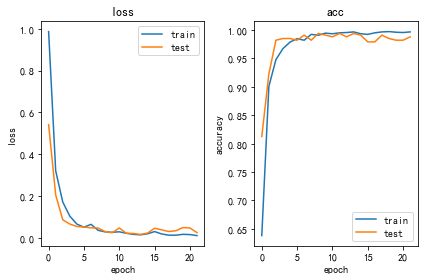

In [18]:
def show_history(history):
    fig, axes = plt.subplots(nrows=1,ncols=2)
    ax=axes[0]

    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    ax.legend(['train','test'],loc='upper right')
    ax.set_title('loss'.format(1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    ax=axes[1]
    ax.plot(history['accuracy'])
    ax.plot(history['val_accuracy'])
    ax.legend(['train','test'],loc='best')
    ax.set_title('acc'.format(1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(root_path,"训练曲线.png"))
    plt.savefig("训练曲线.png")
    plt.show() 
    
show_history(history.history)

## 测试集测试

In [19]:
model_id

200

In [20]:
K.clear_session()
model = None
# trainer.target_fold = r"E:\projects\znyx-trainer\job\resnet_efficient\imgs_me_mang"
model = trainer.load_model(model_id)
# 加载训练中的最优模型
# model.load_weights(trainer.get_weight_file(24))


2022-02-25 13:31:02,372 - INFO - trainer.py - load_model - 353 - load weights 200


find 5 from E:\projects\znyx-trainer\job\口咽部\第7轮_整图\valid_date
load data from fold finished ,count=181
6/6 [==============================] - 1s 196ms/step


2022-02-25 13:31:10,258 - INFO - plot.py - show_matrix - 167 - save plot image to E:\projects\znyx-trainer\job\口咽部\第8轮\2022-02-25-13-31_975.png 
2022-02-25 13:31:10,259 - INFO - plot.py - show_matrix - 174 - accurracy:0.994475138121547


cast-246ms, fold: ['E:\\projects\\znyx-trainer\\job\\口咽部\\第7轮_整图\\valid_date'] ,accurracy:99
Confusion matrix, without normalization
[[90  0  0  0  0]
 [ 0 25  1  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 26  0]
 [ 0  0  0  0  9]]


<Figure size 432x288 with 0 Axes>

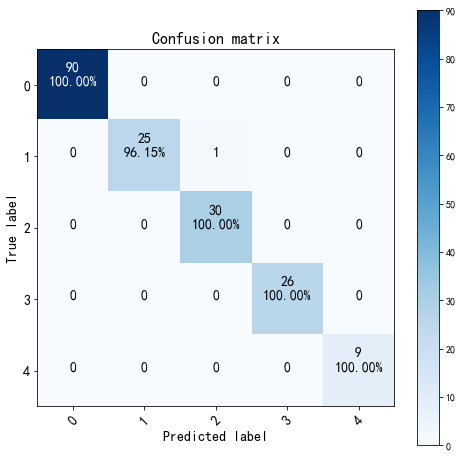

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [21]:
use_increase = True
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
test_path = r"E:\projects\znyx-trainer\job\口咽部\第7轮_整图\valid_date"
acc, y_pred, y_true, file_test = trainer.predict_data([test_path if use_increase else res_test_path], model = model)
path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()

print(desc_list)    

find 5 from E:\projects\znyx-trainer\job\口咽部\第6轮\valid_data
load data from fold finished ,count=170
6/6 [==============================] - 1s 175ms/step


2022-02-23 10:37:54,930 - INFO - plot.py - show_matrix - 167 - save plot image to E:\projects\znyx-trainer\job\口咽部\第6轮\2022-02-23-10-37_383.png 
2022-02-23 10:37:54,931 - INFO - plot.py - show_matrix - 174 - accurracy:0.9588235294117647


cast-58ms, fold: ['E:\\projects\\znyx-trainer\\job\\口咽部\\第6轮\\valid_data'] ,accurracy:95
Confusion matrix, without normalization
[[90  0  0  0  0]
 [ 0 25  1  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 16  0]
 [ 1  0  0  5  2]]


<Figure size 432x288 with 0 Axes>

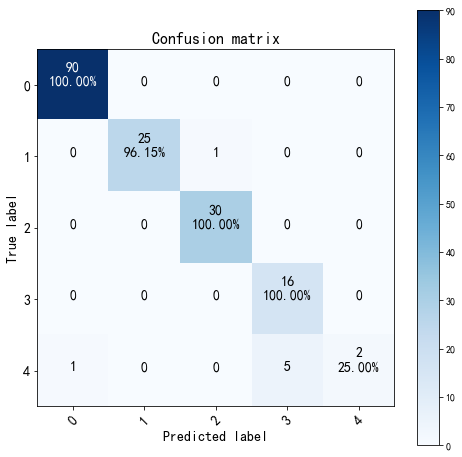

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [9]:
use_increase = True
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
test_path = r"E:\projects\znyx-trainer\job\口咽部\第6轮\valid_data"
acc, y_pred, y_true, file_test = trainer.predict_data([test_path if use_increase else res_test_path], model = model)
path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()

print(desc_list)    

In [ ]:
use_increase = True
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test = trainer.predict_data([test_path if use_increase else res_test_path], model = model,binary_threshold=optimal_threshold)
path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()

print(desc_list)

In [ ]:
acc: 98.51%
0: 98.69%
1: 98.35%

In [20]:
from datetime import datetime
def predict_imgs(imgs_path0,imgs_path1,model):
    # 获取该路径下所有图片
    files_list0=fetch_all_files(imgs_path0,file_exts=[".jpg", ".Jpg", ".jpeg", ".PNG", ".png", ".Bmp", ".bmp", ".BMP", ".JPG"])
    files_list0=sort_by_file_name(files_list0)

    files_list1=fetch_all_files(imgs_path1,file_exts=[".jpg", ".Jpg", ".jpeg", ".PNG", ".png", ".Bmp", ".bmp", ".BMP", ".JPG"])
    files_list1=sort_by_file_name(files_list1)
    
    label0 = [0] * len(files_list0)
    label1 = [1] * len(files_list1)
    files_list = files_list0 + files_list1
    label = label0 + label1
    x_test = []
    X = []

    for file in files_list:
        img = read_img_file(file)
        img = cv2.resize(img,(224,224))
        x_test.append(img)

    for x in x_test:
        x = np.array(x,dtype="float32")
        if x.shape[2] != 3:
            x = x[:, :, :3]
        X.append(x)

    X= np.asarray(X)

    predictions_list = model.predict(X, verbose=1)
    
    start_time = datetime.now().timestamp()
    for x in x_test[:100]:
        x = np.array(x,dtype="float32")
        if x.shape[2] != 3:
            x = x[:, :, :3]
        data = np.expand_dims(x, axis=0)
        predictions = model.predict(data)[0]
    end_time = datetime.now().timestamp()
    during_time = end_time - start_time
    
    return label,predictions_list,files_list,during_time

def cal_acc(label,pred):
    print("阈值   综合精度          灵敏度            特异度   ")
    for tr in [ x for x in range(1,101,1)]:
        tn,tp,P_all,N_all =0,0,0,0

        for i,y_true in enumerate(label):
            if y_true ==0:
                N_all+=1
                if pred[i]>tr:
                    y_pred =1
                else:
                    y_pred =0
                if y_pred == y_true:
                    tn+=1
            if y_true ==1:
                P_all+=1
                if pred[i]>tr:
                    y_pred =1
                else:
                    y_pred =0
                if y_pred == y_true:
                    tp+=1
        
        print(tr,(tp+tn)/(P_all+N_all),tp/P_all,tn/N_all)

In [21]:
from mbsh.core.images import sort_by_file_name,load_img_data,fetch_all_files,read_img_file
imgs_path0 = r"E:\projects\znyx-trainer\job\resnet_efficient\imgs_me_ca\gl_whu_test\0"
imgs_path1 = r"E:\projects\znyx-trainer\job\resnet_efficient\imgs_me_ca\gl_whu_test\1"
label,predictions_list,files_list,time = predict_imgs(imgs_path0,imgs_path1,model)

49/49 [==============================] - 5s 96ms/step


In [22]:
print(time)

3.1885647773742676


In [23]:
pred = []
for prediction in predictions_list:
    conf = (prediction[0])*100
    pred.append(conf)
    
from sklearn.metrics import roc_curve, auc
fpr,tpr,thresholds = roc_curve(label,pred)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("最佳阈值：%s  ROC面积：%s"%(optimal_threshold,roc_auc))

cal_acc(label,pred)

最佳阈值：8.858472853899002  ROC面积：0.9719418564527259
阈值   综合精度          灵敏度            特异度   
1 0.7037037037037037 0.9875776397515528 0.5738636363636364
2 0.8310591293047433 0.9648033126293996 0.7698863636363636
3 0.8745938921377517 0.9565217391304348 0.8371212121212122
4 0.8953866146848602 0.9316770186335404 0.8787878787878788
5 0.907732293697206 0.9109730848861284 0.90625
6 0.9155295646523717 0.8985507246376812 0.9232954545454546
7 0.916829109811566 0.8861283643892339 0.9308712121212122
8 0.9207277452891488 0.8799171842650103 0.9393939393939394
9 0.9259259259259259 0.8674948240165632 0.9526515151515151
10 0.9252761533463287 0.8530020703933747 0.9583333333333334
11 0.9272254710851202 0.8488612836438924 0.9630681818181818
12 0.9259259259259259 0.8364389233954451 0.9668560606060606
13 0.9252761533463287 0.8281573498964804 0.9696969696969697
14 0.9246263807667316 0.8178053830227743 0.9734848484848485
15 0.9246263807667316 0.8115942028985508 0.9763257575757576
16 0.9213775178687459 0.79917184